In [1]:
import os
from glob import glob
import json

source_dir = os.path.join("..", "arxiv_papers_infos")
papers_paths = glob(os.path.join(source_dir, "*.json"))

In [2]:
paper_data = []
for path in papers_paths:
    with open(path, "r") as f:
        data = json.load(f)
    paper_data.append(data)
print(len(paper_data))

320


In [3]:
from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

In [4]:
docs = []
titles = []
for data in paper_data:
    if "result" not in data:
        continue
    data = data["result"]
    authors = "" if "authors" not in data else " ".join(data["authors"])
    title = "" if "title" not in data else data["title"]
    abstract = "" if "abstract" not in data else data["abstract"]
    # sent = authors + " " + title + " " + abstract
    sent = title + " ----- " + abstract
    docs.append(sent)
    titles.append(title)
print(len(docs))

320


In [16]:
embeddings = model.encode(docs[:1000])

#### DBSCAN

In [23]:
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


runs_df = {
    "TSNE perplexity": [],
    "DBSCAN eps": [],
    "DBSCAN min_samples": [],
    "Num. clusters": [],
    "Num. noise": [],
    "Silhouette": [],
}

for perp in range(10, 210, 10):
    X_tsne = TSNE(
        n_components=2,
        learning_rate='auto',
        init='random',
        perplexity=perp
    ).fit_transform(embeddings)
    for _eps in range(1, 20):
        eps = _eps / 4.0
        for min_samples in range(2, 15):
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_tsne)
            labels = db.labels_
            if not (1 < len(set(labels)) < len(X_tsne)):
                sil_score = -1.0
            else:
                sil_score = silhouette_score(X_tsne, labels)
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            runs_df["TSNE perplexity"].append(perp)
            runs_df["DBSCAN eps"].append(eps)
            runs_df["DBSCAN min_samples"].append(min_samples)
            runs_df["Num. clusters"].append(n_clusters_)
            runs_df["Num. noise"].append(n_noise_)
            runs_df["Silhouette"].append(sil_score)

runs_df = pd.DataFrame(runs_df)

# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print(f"Estimated number of clusters: {n_clusters_}")
# print(f"Estimated number of noise points: {n_noise_}")

#### WARD

In [27]:
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


runs_df = {
    "TSNE perplexity": [],
    "Num. clusters": [],
    "Silhouette": [],
}

for perp in range(10, 210, 10):
    X_tsne = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        perplexity=perp
    ).fit_transform(embeddings)
    for num_clusters in range(2, 30):
        db = AgglomerativeClustering(n_clusters=num_clusters, linkage="ward").fit(X_tsne)
        labels = db.labels_
        if not (1 < len(set(labels)) < len(X_tsne)):
            sil_score = -1.0
        else:
            sil_score = silhouette_score(X_tsne, labels)
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        runs_df["TSNE perplexity"].append(perp)
        runs_df["Num. clusters"].append(num_clusters)
        runs_df["Silhouette"].append(sil_score)

runs_df = pd.DataFrame(runs_df)

# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print(f"Estimated number of clusters: {n_clusters_}")
# print(f"Estimated number of noise points: {n_noise_}")

#### Results

In [29]:
pd.set_option("display.max_rows", 180)
display(runs_df.sort_values("Silhouette", ascending=False).iloc[:180])

plt_data = pd.DataFrame(
    {
        "x_tsne": X_tsne[:, 0],
        "y_tsne": X_tsne[:, 1],
        "content": titles[:len(X_tsne)],
    }
)

plt_data["label"] = labels
fig = px.scatter(
    plt_data,
    x="x_tsne",
    y="y_tsne",
    hover_name="content",
    hover_data=["label"],
    color=labels,
)
fig.show()

,TSNE perplexity,Num. clusters,Silhouette
363,130,29,0.384419
362,130,28,0.383546
307,110,29,0.383175
306,110,28,0.381151
305,110,27,0.381061
361,130,27,0.378714
304,110,26,0.375213
335,120,29,0.374678
0,10,2,0.374640
359,130,25,0.374050


In [30]:
from collections import defaultdict as dd

cluster_counts = dd(int)
cluster_titles = dd(list)

for idx, label in enumerate(labels):
    cluster_counts[label] += 1
    cluster_titles[label].append(titles[idx])

In [31]:
sorted_clusters = sorted(cluster_titles.items(), key=lambda x: -len(x[1]))

In [33]:
sorted_clusters[::-1] #[1:]

[(23,
  ['mixture of elm based experts with trainable gating network',
   'fast adaptively weighted matrix factorization for recommendation with implicit feedback',
   'factory of realities: on the emergence of virtual spatiotemporal structures']),
 (25,
  ['dynamically throttleable neural networks (tnn)',
   'gshard: scaling giant models with conditional computation and automatic sharding',
   'dynet: the dynamic neural network toolkit',
   'neurally implementable semantic networks']),
 (22,
  ['sparsity-constrained optimal transport',
   'test-time adaptation via conjugate pseudo-labels',
   'eve: environmental adaptive neural network models for low-power energy harvesting system',
   'an empirical study of batch normalization and group normalization in conditional computation']),
 (27,
  ['siamese labels auxiliary learning',
   'gated embeddings in end-to-end speech recognition for conversational-context fusion',
   'robust sound event detection in bioacoustic sensor networks',
   '

293


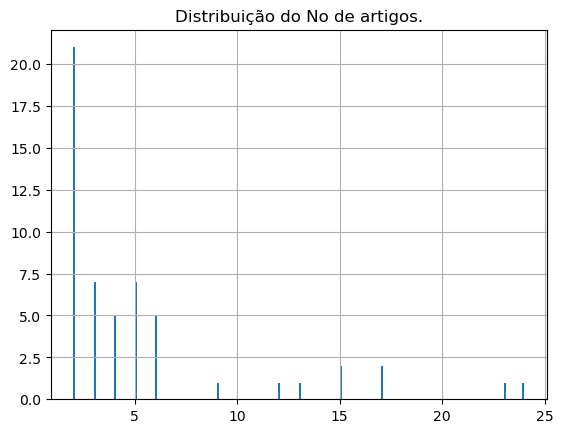

In [45]:
cluster_lenghts = [len(x[1]) for x in sorted_clusters[1:]]
print(sum(cluster_lenghts)) # [1:125]
plt.hist(cluster_lenghts, bins=220)
plt.grid()
plt.title("Distribuição do No de artigos.")
plt.show()